### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from model.lorenz96 import Lorenz96
from model.parameter import Parameter
from filtering.enkf import EnKF
from utils import default_generator
from utils.plotter import Plotter
from utils.compare import Comparator

Plotter.fig_folder = "figs_param_estim_l96"

### Parameters

In [2]:
generator = default_generator
# generator = np.random.default_rng(9999)
F = 8.0
forcing = Parameter(init_value=F, uncertainty=0.5, name="$F$", estimate=True)
n_states = 20

time_step = 0.05
init_time = 0
end_time = 20
ensemble_size = 40

x0_unperturbed = generator.normal(size=n_states)
x0 = x0_unperturbed.copy()
x0 += 0
# x0 = F * np.ones(n_states)

initial_state_covariance = 0.5 * np.eye(n_states)
system_cov = lambda _: 0.5 * np.eye(n_states)
obs_cov = lambda _: 0.3 * np.eye(n_states)

H = lambda _: np.eye(n_states)

### Generate true state

In [3]:
model = Lorenz96(
    x0_unperturbed,
    time_step,
    n_states,
    forcing,
    H,
    system_cov,
    obs_cov,
    generator,
    solver="rk4",
)
times, states = model.integrate(init_time, end_time)

### Generate observations (with noise)

In [4]:
assimilation_step = 1
assimilation_times = np.linspace(1, end_time, int(end_time / assimilation_step))
observed = np.zeros((n_states, len(assimilation_times)))
observed_true = np.zeros((n_states, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / time_step)
    observed[:, i] = model.observe(states[:, k], add_noise=True)
    observed_true[:, i] = model.observe(states[:, k])

### EnKF twin experiment

In [5]:
# Modify the parameter to be estimated
cut_off_time = 15
perturbed_F = F - 4
model.reset_model(x0)
model.uncertain_parameters = np.array([perturbed_F])
model.uncertain_parameters[0].init_value = perturbed_F
f = EnKF(
    model,
    x0,
    initial_state_covariance,
    ensemble_size,
    generator=generator,
    loc_radius=None,
)

results = f.filter(
    assimilation_times,
    observed_true,
    cut_off_time=cut_off_time,
)
results.true_times = times
results.true_states = states
results.figsize = "horizontal"

100%|██████████| 20/20 [00:01<00:00, 12.18it/s]

Localize: False


In [6]:
# Run with localization
model.reset_model(x0)
model.uncertain_parameters = np.array([perturbed_F])
model.uncertain_parameters[0].init_value = perturbed_F
f = EnKF(
    model,
    x0,
    initial_state_covariance,
    ensemble_size,
    generator=generator,
    loc_radius=3,
)

results_loc = f.filter(
    assimilation_times,
    observed_true,
    cut_off_time=cut_off_time,
)

100%|██████████| 20/20 [00:01<00:00, 12.00it/s]

Localize: True


KeyboardInterrupt: 

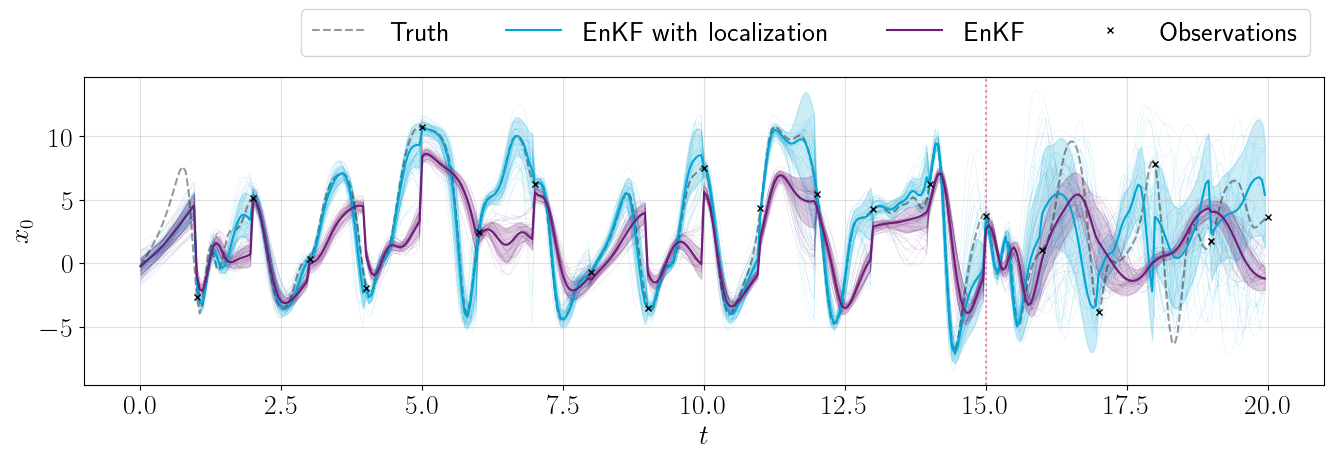

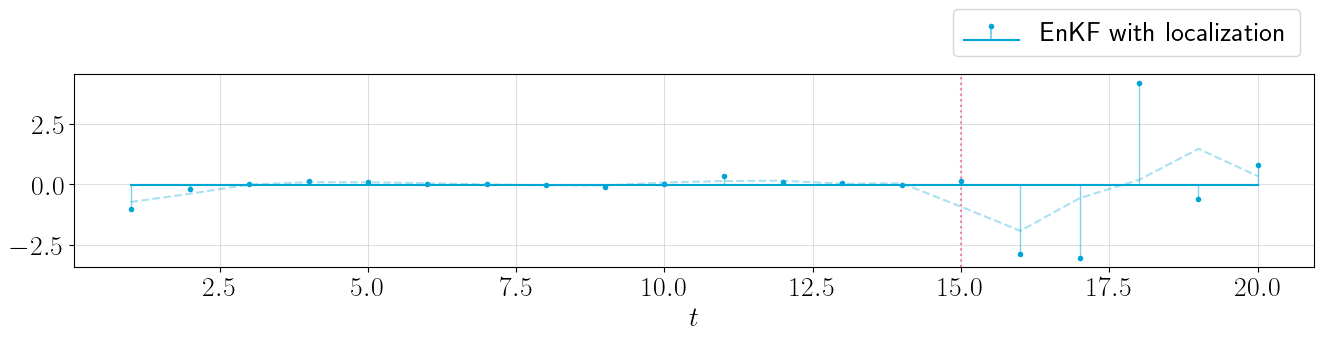

In [7]:
c = Comparator([results_loc, results], ["EnKF with localization", "EnKF"])

idxs = [0]
for i in idxs:
    c.compare_filtering(
        state_idx=i,
        plot_ensemble=True,
        plot_bands=True,
        figsize="horizontal",
        path=f"compare_x{i}",
    )
    c.compare_innovations(
        state_idx=i, figsize="standard", window=3, path=f"compare_inn_x{i}"
    )
plt.show()

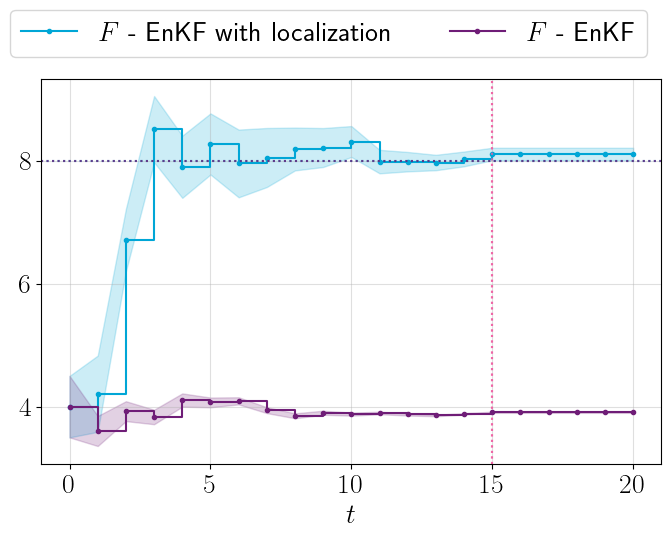

In [ ]:
# refs = [F]
# results.plot_params([0], refs, path="params")
if forcing.estimate:
    c.compare_params([0], ref_params=[F], path="params")

<Axes: xlabel='Average innovations per state', ylabel='Frequency'>

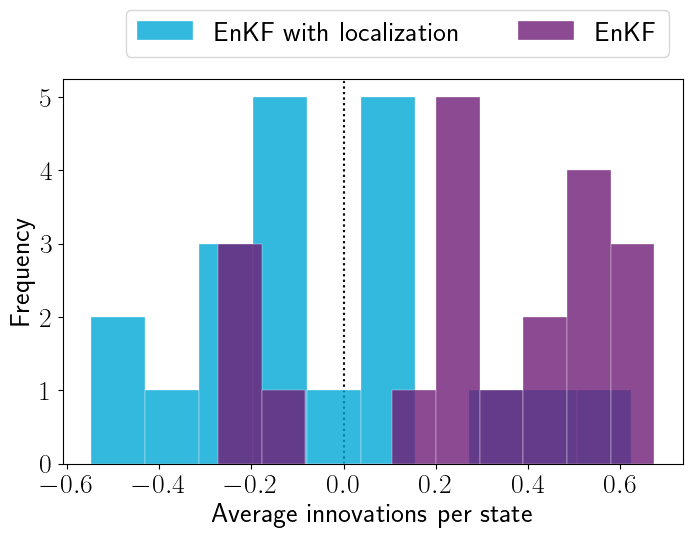

In [ ]:
c.compare_av_innovations(alpha=0.8, path="av_innov")